# Helper code

In [ ]:
from plotly.offline import init_notebook_mode; init_notebook_mode()

In [ ]:
BUCKET_NAME="beeflow-dev-metadata-dumps"

import pandas as pd
import boto3
import plotly.express as px

s3 = boto3.client('s3') 

s3_cache = {}

def get_s3_csv(file: str):
    if file in s3_cache:
        return s3_cache[file]
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=file)
    df = pd.read_csv(obj['Body'])
    s3_cache[file] = df
    return df


from enum import Enum

class System(Enum):
    MWAA = "mwaa"
    BEEFLOW = "serverless"
    
class Stats(Enum):
    DAG_RUNS = "dagrun"
    TASKS = "taskinstance"
    
def get_stats(system: System, date: str, stats: Stats):
    return get_s3_csv(f"{system.value}/export/{stats.value}/dt={date}/{stats.value}.csv")

def filter_on_dag_ids(df, dag_ids):
    return df[df['dag_id'].isin(dag_ids)]

def filter_on_not_task_ids(df, task_ids):
    return df[~df['task_id'].isin(task_ids)]

def filter_on_not_dag_run_id(df, dag_run_ids):
    return df[~df['run_id'].isin(dag_run_ids)]
    

In [ ]:
def enhance_with_duration(df):
    start_ms_time = pd.to_datetime(df['start_date'])
    end_ms_time = pd.to_datetime(df['end_date'])
    df['duration'] = end_ms_time.sub(start_ms_time).dt.total_seconds()
    
def enhance_with_wait_time_dag_runs(df):
    queued_ms_time = pd.to_datetime(df['queued_at'])
    end_ms_time = pd.to_datetime(df['start_date'])
    df['wait_time'] = end_ms_time.sub(queued_ms_time).dt.total_seconds()
    
def enhance_with_wait_time_tasks(df):
    queued_ms_time = pd.to_datetime(df['queued_dttm'])
    end_ms_time = pd.to_datetime(df['start_date'])
    df['wait_time'] = end_ms_time.sub(queued_ms_time).dt.total_seconds()

In [ ]:
from dataclasses import dataclass
from typing import List

@dataclass
class BoxPlotEntry:
    data: pd.DataFrame
    identifier: str

In [ ]:
def box_plot_for(entries: List[BoxPlotEntry], measured_column="duration", hide_x_axis=False, **kwargs):
    transformed_data = []
    for entry in entries:
        df = entry.data.loc[:, ]
        df["identifier"] = entry.identifier
        transformed_data.append(df)
    transformed_data = pd.concat(transformed_data)
    fig = px.box(transformed_data, x="identifier", y=measured_column, color="identifier", points="all", **kwargs)
    if hide_x_axis:
        fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

In [ ]:
@dataclass
class BoxPlotsEntry:
    system: System
    export_date: str
    dag_ids: List[str]
    task_duration: int
    tasks_count: int
    additional_metadata: str = ""

In [ ]:
def box_plots_for(entries: List[BoxPlotsEntry], not_task_ids, not_dag_run_ids=[], hide_x_axis=False, **kwargs):
    dags_data = []
    task_duration = None
    
    for entry in entries:
        task_duration = entry.task_duration
        entry_dag_runs = filter_on_not_dag_run_id(
            df=filter_on_dag_ids(
                df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
                dag_ids=entry.dag_ids,
            ),
            dag_run_ids=not_dag_run_ids,
        )
        enhance_with_duration(entry_dag_runs)
        enhance_with_wait_time_dag_runs(entry_dag_runs)
        
        dags_data.append(
            BoxPlotEntry(
                data=entry_dag_runs,
                identifier=f"{entry.system.value}_tasks:{entry.tasks_count}_duration:{entry.task_duration}_additional:{entry.additional_metadata}",
            )
        )
        
    box_plot_for(dags_data, 
                 measured_column="duration", 
                 title="DAG runs comparison: duration",
                 hover_data=["run_id"],
                 hide_x_axis=hide_x_axis,
                 **kwargs)
    
    tasks_data = []
    
    for entry in entries:
        entry_tasks = filter_on_not_dag_run_id(
            df=filter_on_not_task_ids(
                df=filter_on_dag_ids(
                    df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.TASKS), 
                    dag_ids=entry.dag_ids,
                ),
                task_ids=not_task_ids,
            ),
            dag_run_ids=not_dag_run_ids,
        )
        enhance_with_duration(entry_tasks)
        enhance_with_wait_time_tasks(entry_tasks)
        
        tasks_data.append(
            BoxPlotEntry(
                data=entry_tasks,
                identifier=f"{entry.system.value}_tasks:{entry.tasks_count}_duration:{entry.task_duration}_additional:{entry.additional_metadata}",
            )
        )
    
    box_plot_for(tasks_data,
                 measured_column="duration", 
                 title=f"Tasks runs comparison: task duration (ideal: {task_duration}s)",
                 hide_x_axis=hide_x_axis,
                 **kwargs)
    box_plot_for(tasks_data,
                 measured_column="wait_time", 
                 title="Tasks run comparision: wait time (amount of time passed from task being marked as queued to started)",
                 hide_x_axis=hide_x_axis,
                 **kwargs)
        

In [ ]:
def trend_for(data: pd.DataFrame, x_col="tasks_count", measured_column="duration", **kwargs):
    # display(data)
    fig = px.line(data, x=x_col, y=measured_column, color="identifier", **kwargs)
    if "hide_x_axis" in kwargs:
        fig.update_xaxes(visible=False, showticklabels=False)
    fig.show()

In [ ]:
def trends_for(entries: List[BoxPlotsEntry], not_task_ids, not_dag_run_ids=[], **kwargs):
    dags_data = []
    
    for entry in entries:
        task_duration = entry.task_duration
        entry_dag_runs = filter_on_not_dag_run_id(
            df=filter_on_dag_ids(
                df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
                dag_ids=entry.dag_ids,
            ),
            dag_run_ids=not_dag_run_ids,
        )
        enhance_with_duration(entry_dag_runs)
        enhance_with_wait_time_dag_runs(entry_dag_runs)
        
        dags_data.append(
            {
                "median_duration": entry_dag_runs["duration"].median(),
                "identifier": f"{entry.system.value}",
                "tasks_count": entry.tasks_count,
            }
        )
        
    trend_for(data=pd.DataFrame(dags_data), measured_column="median_duration", title="Median DAG duration", **kwargs)
    
    tasks_data = []
    for entry in entries:
        entry_tasks = filter_on_not_dag_run_id(
            df=filter_on_not_task_ids(
                df=filter_on_dag_ids(
                    df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.TASKS), 
                    dag_ids=entry.dag_ids,
                ),
                task_ids=not_task_ids,
            ),
            dag_run_ids=not_dag_run_ids,
        )
        enhance_with_duration(entry_tasks)
        enhance_with_wait_time_tasks(entry_tasks)
        
        tasks_data.append(
            {
                "median_duration": entry_tasks["duration"].median(),
                "median_wait_time": entry_tasks["wait_time"].median(),
                "identifier": f"{entry.system.value}",
                "tasks_count": entry.tasks_count,
            }
        )
        
    
    trend_for(data=pd.DataFrame(tasks_data), measured_column="median_duration", title="Median Tasks duration", **kwargs)
    trend_for(data=pd.DataFrame(tasks_data), measured_column="median_wait_time", title="Median Tasks waittime", **kwargs)
    
        

In [ ]:
from IPython.display import display


def print_tables(entries: List[BoxPlotsEntry]):
    for entry in entries:
        entry_dag_runs = filter_on_dag_ids(
            df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
            dag_ids=entry.dag_ids,
        )
        enhance_with_duration(entry_dag_runs)
        print(entry.system)
        display(entry_dag_runs[["duration", "run_id", "start_date", "end_date", "_state"]])

# Points

## Beeflow's performance for line DAG's rivals MWAA

 ## Beeflow's more performant for warm starts (parallel)

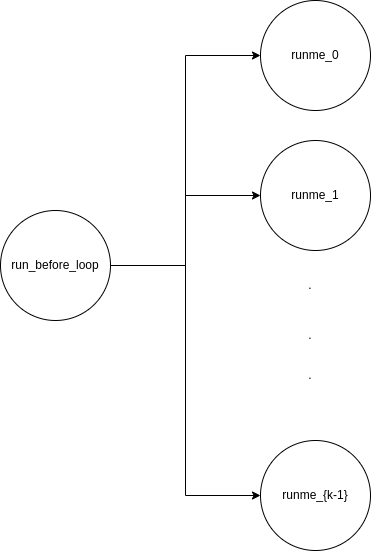

For this experiment, the following configuration was applied:

1. Beeflow
- `db.small` was used instead of `db.micro`
- the DB allows  for  around 170 concurrent connections, the cost of `db.micro` is `~14$`, while `db.small` is double that (`28`)
- `db.micro` is free under the free tier, that allows for `~85` concurrent connections, so highly parallel tests were throttled heavily
- `MWAA` seems to use something between `db.small` and `db.medium` (pulled from metrics, there is no official info on this)
- thus the comparision is fair, more on this later, the db is the single point of failure and the bottleneck of the system
- another possibility and what MWAA leverages is [a managed proxy service on AWS](https://aws.amazon.com/rds/proxy/) but GCP doesn't seem to have the equivalent (TO CONFIRM)
- the proxy costs `21$+` a month, so the `db.small` upgrade was chosen
- the rest of the setup stays the same
- beeflow lambdas for scheduler uses: 512MB mem -> ~1/3 vCPU
- beeflow worker lambdas use: 512MB mem -> ~1/3 vCPU (but the only thing they do is sleep)

2. MWAA
- small environment (limits scheduler to 1vCPU)
- 20 workers min, 20 workers max
- 10 tasks per worker
- one worker has 1 vCPU and 2GB RAM (but again, the tasks in both sleep, so it doesn't matter much)

### 20 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_17-28",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_17-39",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], height=700, width=1500)

### 40 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_18-57",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_19-09",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], height=700, width=1500)

### 80 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_20-38",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], height=700, width=1500)

### 160 tasks

In this case MWAA also started to throw some transient errors, 2 DAG runs have not finished in time,
a couple of tasks run for ~5minutes. Excluding these from the diagram for the sake of a proper comparison

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_21-55",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_22-07",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
from IPython.display import display


for entry in entries:
    entry_dag_runs = filter_on_dag_ids(
        df=get_stats(system=entry.system, date=entry.export_date, stats=Stats.DAG_RUNS), 
        dag_ids=entry.dag_ids,
    )
    enhance_with_duration(entry_dag_runs)
    print(entry.system)
    display(entry_dag_runs[["duration", "run_id", "start_date", "end_date", "_state"]])

In [ ]:
box_plots_for(entries=entries, 
              not_task_ids=["run_before_loop"], 
              not_dag_run_ids=["scheduled__2023-01-07T21:45:00+00:00", "scheduled__2023-01-07T21:35:00+00:00"], 
              height=700, 
              width=1500)

### Trends

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_17-28",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_17-39",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_18-57",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_19-09",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_20-38",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_21-55",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_22-07",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
trends_for(entries, not_task_ids=[])

## Beeflow's performance for cold stars rivals warm MWAA environment (parallel)

The setup in this experiment is exactly the same as in the previous one with warm start.
The difference is that the DAG was running on 30mins cron, instead of 5mins, thus, making
all the lambda start from `cold` invocations for each subsystem in Beeflow.

### 20 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_17-28",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_16-35",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t_30cron"],
        additional_metadata="db.small_30mincron_coldstart",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_17-39",
        tasks_count=20,
        task_duration=10,
        dag_ids=["10s_20t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
print_tables(entries)

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], not_dag_run_ids=["scheduled__2023-01-08T14:30:00+00:00"], height=700, width=1500, hide_x_axis=True)

### 40 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_18-57",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_18-35",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t_30cron"],
        additional_metadata="db.small_coldstarts",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_19-09",
        tasks_count=40,
        task_duration=10,
        dag_ids=["10s_40t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
print_tables(entries)

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], not_dag_run_ids=["scheduled__2023-01-08T16:30:00+00:00"], height=700, width=1500, hide_x_axis=True)

### 80 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_20-26",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_20-36",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t_30cron"],
        additional_metadata="db.small_coldstarts",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_20-38",
        tasks_count=80,
        task_duration=10,
        dag_ids=["10s_80t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
print_tables(entries)

In [ ]:
box_plots_for(entries=entries, 
              not_task_ids=["run_before_loop"], 
              not_dag_run_ids=["scheduled__2023-01-08T18:30:00+00:00"], height=700, width=1500, hide_x_axis=True)

### 160 tasks

In [ ]:
entries = [
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-07_21-55",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="db.small",
    ),
    BoxPlotsEntry(
        system=System.BEEFLOW,
        export_date="2023-01-08_22-38",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t_30cron"],
        additional_metadata="db.small_coldstarts",
    ),
    BoxPlotsEntry(
        system=System.MWAA,
        export_date="2023-01-07_22-07",
        tasks_count=160,
        task_duration=10,
        dag_ids=["10s_160t"],
        additional_metadata="20workers{min==max}_10task{for worker}",
    ),
]

In [ ]:
print_tables(entries)

In [ ]:
box_plots_for(entries=entries, not_task_ids=["run_before_loop"], 
              not_dag_run_ids=["scheduled__2023-01-07T21:45:00+00:00", "scheduled__2023-01-07T21:35:00+00:00", "scheduled__2023-01-08T20:30:00+00:00"], 
              hide_x_axis=True,
              height=700, width=1500)

## Beeflow's autoscaling is faster (parallel)